## US Wildfires 1992-2015. Analysis and visualizations

DATA: Database contains information on 1.88 milion of wildfires. All are geolocalized, have informations on agencies responsible for land management etc, contain informations on discovery and containment dates, size of fire.

GOALS: In this notebook i will perform quantitive analyses to find where the fires occur most commonly, where they are biggest, if the fires occur more or less commonly now and visualize it.

In [34]:
import time
import pandas as pd
import numpy as np
import sqlite3
import os
from datetime import date, timedelta
import datetime
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile
import geopandas as gpd
from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *
from scripts import *

In [35]:
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

In [36]:
# establishing db connection

con = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [37]:
# viewing tables in databes

cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

From the dataset description we can learn that table Fires is the one containing info on wildfires themselves. Lets view it and save it as pandas dataframe for later use

In [38]:
# first look on all data
data = pd.read_sql_query("SELECT * FROM Fires",con)
data.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.04,-121.01,5.00,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.93,-120.40,5.00,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.98,-120.74,13.00,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.56,-119.91,5.00,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.56,-119.93,5.00,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Let's starts by locating states with most wildfires, biggest wildfires etc

In [39]:
pd.read_sql_query("""SELECT * FROM Fires""", con).columns


Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [40]:
# States with most wildfires

most_fires = pd.read_sql_query("""SELECT STATE, COUNT(*) as count
FROM Fires
GROUP BY STATE
ORDER BY count DESC
""", con)

most_fires = most_fires.rename({"STATE":"STUSPS"},axis=1)

most_fires

,STUSPS,count
0,CA,189550
1,GA,168867
2,TX,142021
3,NC,111277
4,FL,90261
5,SC,81315
6,NY,80870
7,MS,79230
8,AZ,71586
9,AL,66570


In [41]:
# reading vector map
shp_path = "cb_2018_us_state_500k.shp"

# creating GeoDataFrame with data and map info
map_df = gpd.read_file(shp_path)
map_df = map_df.merge(most_fires, on="STUSPS")
map_df["count"].min()

66

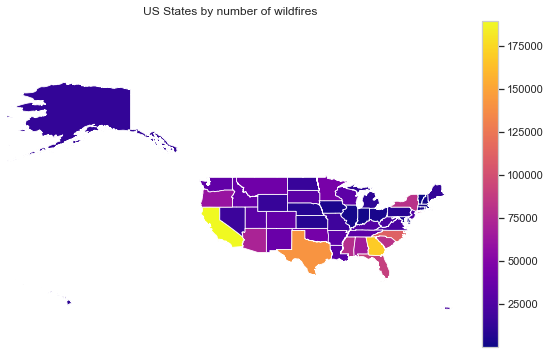

In [42]:
vmin, vmax = map_df["count"].min(), map_df["count"].max()
sm = plt.cm.ScalarMappable(cmap = "plasma",norm=plt.Normalize(vmin=vmin, vmax=vmax))

fig, ax = plt.subplots(1)
map_df.plot(column="count",cmap="plasma", ax=ax ,linewidth=0.8)
cbar = fig.colorbar(sm)
plt.axis("equal")
plt.xlim(-170,-65)
plt.ylim(20,75)
plt.axis("off")
plt.title("US States by number of wildfires")
plt.show()

States with most wildfires are: California, Georgia, Texas and North Carolina.

Finding and visualising 100 biggest wildfires in dataset

In [43]:
# 100 biggest wildfires


biggest_fires = pd.read_sql_query("""SELECT STATE, FIRE_YEAR,FIRE_SIZE,LONGITUDE,LATITUDE
FROM Fires
ORDER BY FIRE_SIZE DESC
LIMIT 100""", con)

In [44]:
#  creating GeoDataFrame - python table type for storing geographical data
gdf = geodf_create_transform(biggest_fires,"LONGITUDE","LATITUDE","FIRE_SIZE")

C:\Users\szklarnia\Desktop\datascience\projekty\us wildfires\scripts.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.x_crds[i] = list(gdf.geometry[i].coords)[0][0]
C:\Users\szklarnia\Desktop\datascience\projekty\us wildfires\scripts.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.y_crds[i] = list(gdf.geometry[i].coords)[0][1]


In [45]:
# creating ColumnDataSource for plotting with Bokeh
source = ColumnDataSource(gdf.drop("geometry",axis=1))

In [46]:
# creating points
x_range,y_range = get_max_min(-170,-70,70,20)

In [47]:
# creating bubble plot
p = plot_bubble_map(df=gdf,
               source=source,
               radius_col="resized",
               hover_tuples=[("Size [in acres]:","@FIRE_SIZE"),("Year:","@FIRE_YEAR"),("State:","@STATE")],
               x_range=x_range,
               y_range=y_range,
               title = "Biggest wildfires in the US from 1992 to 2015",
               leg_label = "Wildfires by size")

Loading BokehJS ...

Out of 10 biggest wildfires to 2015, none of them occured in two states with biggest amount of fires

Creating and visualizing burned area by state

In [48]:
# combined area burned in all wildfres by state

# fixing pandas option - floats instead of scientific notation in dataframes in this file
pd.options.display.float_format = '{:,.2f}'.format


area_burned = pd.read_sql_query("""SELECT STATE, COUNT(*) as count, SUM(FIRE_SIZE) as Total_acres_burned
FROM Fires
GROUP BY STATE
ORDER BY Total_acres_burned DESC
""", con)
area_burned = area_burned.rename({"STATE":"STUSPS"},axis=1)
area_burned

,STUSPS,count,Total_acres_burned
0,AK,12843,"32,233,094.24"
1,ID,36698,"13,684,334.92"
2,CA,189550,"12,745,858.57"
3,TX,142021,"9,786,218.31"
4,NV,16956,"9,015,855.34"
5,OR,61088,"8,412,801.37"
6,NM,37478,"6,380,041.76"
7,MT,40767,"6,279,526.12"
8,AZ,71586,"5,576,680.93"
9,WA,33513,"4,782,218.31"


In [49]:
# reading vector map for plotting
shp_path = "cb_2018_us_state_500k.shp"

map_df = gpd.read_file(shp_path)
map_df = map_df.merge(area_burned, on="STUSPS")
map_df["count"].min()

66

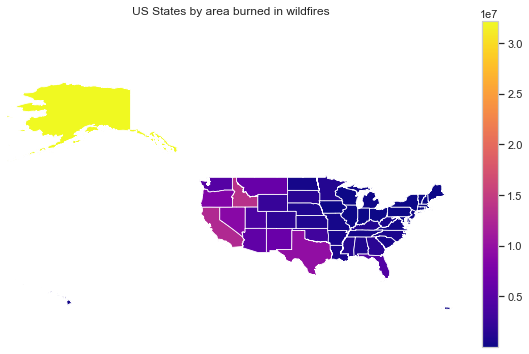

In [50]:
# creating a map visualizing amount of acres burned by state

# creating color bar
vmin, vmax = map_df["Total_acres_burned"].min(), map_df["Total_acres_burned"].max()
sm = plt.cm.ScalarMappable(cmap = "plasma",norm=plt.Normalize(vmin=vmin, vmax=vmax))

# creating map plot
fig, ax = plt.subplots(1)
map_df.plot(column="Total_acres_burned",cmap="plasma", ax=ax ,linewidth=0.8)
# adding color bar
cbar = fig.colorbar(sm)
plt.axis("equal")
plt.xlim(-170,-65)
plt.ylim(20,75)
plt.axis("off")
plt.title("US States by area burned in wildfires")
plt.show()

States in total land burned table are ordered differently than in most wildfires table. Alaska and Idaho are at the top, probably because of it's remoteness and sparse population, allowing fires to grow bigger before efforts to contain them are undertaken. Let's now check mean size of fire by state

In [51]:
# mean size of fire by state

pd.read_sql_query("""SELECT STATE, COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
GROUP BY STATE
ORDER BY AVG_fire_size DESC
""", con)


,STATE,count,AVG_fire_size
0,AK,12843,"2,509.78"
1,NV,16956,531.72
2,ID,36698,372.89
3,NM,37478,170.23
4,WY,14166,169.52
5,MT,40767,154.03
6,WA,33513,142.70
7,OR,61088,137.72
8,UT,30725,133.93
9,NE,7973,121.33


As predicted, mean fire size are largest in big, sparsely populated states or states with large mountainous regions. In Alaska, biggest state with one of the smallest populations, mean fire size is 5 times bigger then second Nevada!

In [52]:
# Now let's take our analysis to a county level for a moment -- counties with most wildfires

pd.read_sql_query("""SELECT COUNTY, STATE, COUNT(*) as count
FROM Fires
GROUP BY COUNTY
ORDER BY count DESC
LIMIT 20
""", con)

,COUNTY,STATE,count
0,None,CA,678148
1,5,CA,7576
2,Lincoln,ID,7405
3,SUFFOLK,NY,7373
4,Polk,OR,6955
5,Washington,UT,6916
6,Cherokee,GA,6796
7,Oahu,HI,6777
8,Marion,OR,6657
9,Jackson,OR,6305


Unfortunately, lots of county data is missing in california, so the image is a bit fuzzy here.

Next, let's run some questions by time

In [53]:
# most fires by year

yearly = pd.read_sql_query("""SELECT FIRE_YEAR, COUNT(*) as number
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY FIRE_YEAR DESC
""", con)
yearly

,FIRE_YEAR,number
0,2015,74491
1,2014,67753
2,2013,64780
3,2012,72769
4,2011,90552
5,2010,79889
6,2009,78325
7,2008,85378
8,2007,95573
9,2006,114004


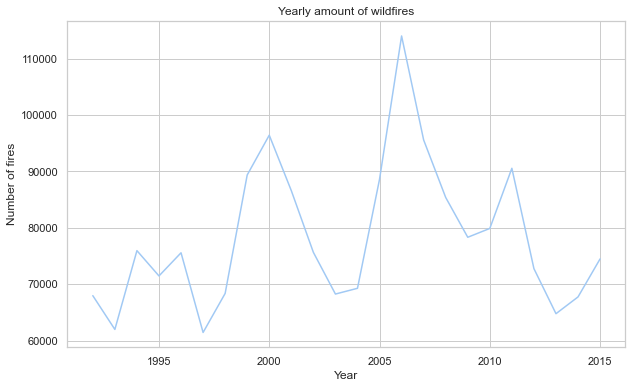

In [54]:
# plotting
plt.plot(yearly.FIRE_YEAR,yearly.number)
plt.title("Yearly amount of wildfires")
plt.xlabel("Year")
plt.ylabel("Number of fires")
plt.show()

There seems to be no pattern as to number of wildfires reported yearly. Data is from 2015, and it might be a little surprising to see this remembering for ex. California wildfires from 2020. Let's consider yearly amount of burned area, and mean fire size per year and amount of fires from sizeclass F and G

In [55]:
# yearly data by burned area

yearly_burned = pd.read_sql_query("""SELECT FIRE_YEAR, COUNT(*) as count, SUM(FIRE_SIZE) as Total_acres_burned
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY Total_acres_burned DESC
""", con)
yearly_burned

,FIRE_YEAR,count,Total_acres_burned
0,2015,74491,"10,218,267.62"
1,2006,114004,"10,043,497.91"
2,2005,88604,"9,665,105.13"
3,2011,90552,"9,623,597.29"
4,2012,72769,"9,439,888.45"
5,2007,95573,"9,265,428.73"
6,2004,69279,"8,234,208.17"
7,2000,96416,"7,639,498.64"
8,2002,75656,"6,803,258.40"
9,1999,89363,"6,080,199.72"


In [56]:
yearly_burned.sort_values(by="FIRE_YEAR",inplace=True)

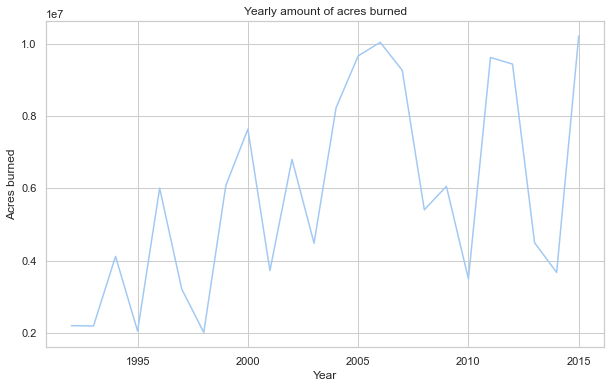

In [57]:
# plotting
plt.plot(yearly_burned.FIRE_YEAR,yearly_burned.Total_acres_burned)
plt.title("Yearly amount of acres burned")
plt.xlabel("Year")
plt.ylabel("Acres burned")
plt.show()

This table seems to display some pattern. Only one year from ten with biggest burned area is from 1990s, and it is 1999, ten in the statistics. Three out of five are from 2010s.

In [58]:
# mean fire size by year

yearly_mean = pd.read_sql_query("""SELECT FIRE_YEAR, COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
GROUP BY FIRE_YEAR
ORDER BY AVG_fire_size DESC
""", con)

In [59]:
yearly_mean.sort_values(by="FIRE_YEAR",inplace=True)

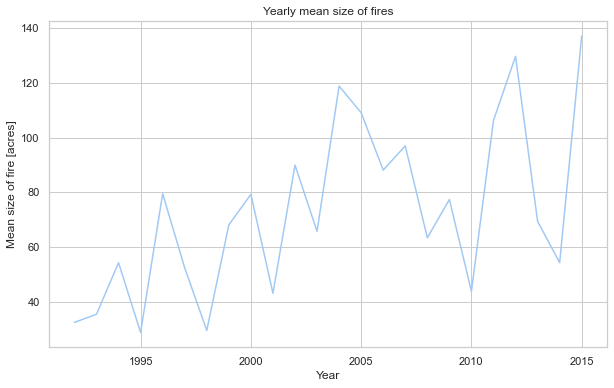

In [60]:
# plotting
plt.plot(yearly_mean.FIRE_YEAR,yearly_mean.AVG_fire_size)
plt.title("Yearly mean size of fires")
plt.xlabel("Year")
plt.ylabel("Mean size of fire [acres]")
plt.show()

Avg fire sizes also seem to get bigger with time, with trends simillar to area burned. We could try to group years into decades and see if the pattern becomes clearer

In [61]:
# 1990s

pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 1992 and 1999
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,572148,48.71


In [62]:
# 2000s

pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 2000 and 2009
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,858083,83.12


In [63]:
#2010

pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 2010 and 2015
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,450234,90.93


Now there is clear and visible difference between fire sizes in the 90s and after 2000. In 2010s fires were averagely twice as large as in 90s

Now let's take a closer look on california, the state affected by devastating wildfires in 2020. Is the trend especially visible there? 

In [64]:
# mean size and number of wildfires in california

pd.read_sql_query("""SELECT FIRE_YEAR, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE STATE = "CA"
GROUP BY FIRE_YEAR
ORDER BY AVG_fire_size DESC
""", con)

,FIRE_YEAR,AVG_fire_size
0,2008,184.68
1,2003,130.41
2,2015,115.24
3,2012,106.10
4,2007,102.97
5,2006,98.26
6,1999,90.25
7,2014,84.21
8,1996,77.09
9,2002,72.19


In [65]:
# yearly amount of fires in CA
pd.read_sql_query("""SELECT FIRE_YEAR, COUNT(*) as count
FROM Fires
WHERE STATE = "CA"
GROUP BY FIRE_YEAR
ORDER BY count DESC
""", con)

,FIRE_YEAR,count
0,1992,10833
1,2007,10151
2,1996,9173
3,1999,8910
4,2013,8723
5,1994,8654
6,2011,8562
7,2006,8271
8,1993,8270
9,2001,8182


These two tables seem to imply that wile number of fires have not change or even decreased slightly, the avg fire size has grown bigger

In [66]:
# average fire size for 1990s
pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 1990 and 1999 AND STATE="CA"
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,68015,47.60


In [67]:
# average fire size for 2000s

pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 2000 and 2009 AND STATE="CA"
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,77407,83.37


In [68]:
# average fire size for 2010s

pd.read_sql_query("""SELECT  COUNT(*) as count, AVG(FIRE_SIZE) as AVG_fire_size
FROM Fires
WHERE FIRE_YEAR between 2010 and 2015 AND STATE="CA"
ORDER BY AVG_fire_size DESC
""", con)

,count,AVG_fire_size
0,44128,69.23


It seems that the size of the fires have indeed increased, however there is a significant drop in comparison between 2000s and 2010s, indicating temporary trend breakdown.



Visualizing wildfires in CA in 2014 - static

In [69]:
# reading data from database
cali_fires = pd.read_sql_query("""SELECT STATE, FIRE_SIZE_CLASS,FIRE_SIZE, LONGITUDE, LATITUDE, FIRE_YEAR,
date(DISCOVERY_DATE) as DISCOVERY_DATE,date(CONT_DATE) as CONT_DATE
FROM Fires
WHERE STATE = "CA" and FIRE_YEAR = 2014
""", con)

In [70]:
cali_fires

,STATE,FIRE_SIZE_CLASS,FIRE_SIZE,LONGITUDE,LATITUDE,FIRE_YEAR,DISCOVERY_DATE,CONT_DATE
0,CA,A,0.10,-123.43,41.88,2014,2014-06-09,2014-06-09
1,CA,A,0.10,-123.28,41.86,2014,2014-07-22,2014-07-22
2,CA,A,0.10,-123.11,41.75,2014,2014-07-11,2014-07-11
3,CA,A,0.10,-123.13,41.93,2014,2014-07-11,2014-07-11
4,CA,B,0.50,-123.32,41.56,2014,2014-07-13,2014-07-14
...,...,...,...,...,...,...,...,...
6489,CA,A,0.25,-121.03,39.07,2014,2014-09-14,2014-09-14
6490,CA,B,1.50,-118.88,36.45,2014,2014-08-13,2014-08-13
6491,CA,A,0.10,-120.97,38.28,2014,2014-03-13,2014-03-13
6492,CA,B,1.00,-120.72,38.34,2014,2014-03-13,2014-03-13


In [71]:
# translating classes into numerical values
cali_fires.FIRE_SIZE_CLASS = cali_fires.FIRE_SIZE_CLASS.map({"A":1,"B":4,"C":8,"D":12,"E":15,"F":20,"G":30})

In [72]:
# creating geo data frame
cali_gdf = geodf_create_transform(cali_fires,"LONGITUDE","LATITUDE",to_resize="FIRE_SIZE_CLASS",resize=0.001)

C:\Users\szklarnia\Desktop\datascience\projekty\us wildfires\scripts.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.x_crds[i] = list(gdf.geometry[i].coords)[0][0]
C:\Users\szklarnia\Desktop\datascience\projekty\us wildfires\scripts.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.y_crds[i] = list(gdf.geometry[i].coords)[0][1]


In [73]:
# dropping geometr column
cali_gdf.drop("geometry",axis=1,inplace=True)

In [74]:
# specyfying range of the map
cali_max_x, cali_max_y = get_max_min(-111,-128 ,32 ,43)

In [79]:
# creating bokeh data source
cali_source = ColumnDataSource(cali_gdf)

# plotting map
plot = plot_bubble_map(df=cali_gdf,
               source=cali_source,
               radius_col="resized",
               hover_tuples=[("Size [in acres]:","@FIRE_SIZE"),("Discovered:","@DISCOVERY_DATE"),("Contained:","@CONT_DATE")],
               x_range=cali_max_x,
               y_range=cali_max_y,
               title = "Wildfires in California in 1992",
               leg_label = "Wildfires by size")


Loading BokehJS ...

Dynamic plot avaliable in Visualizations - 2014 CA Fires

Let's try to find longest burning wildfires

In [76]:
# longest burning fires
pd.read_sql_query("""SELECT STATE, COUNTY, FIRE_SIZE, date(DISCOVERY_DATE) as DISCOVERY,
date(CONT_DATE) as CONTAINMENT, (julianday(CONT_DATE)-julianday(DISCOVERY_DATE)) as LENGHT
FROM Fires
WHERE FIRE_SIZE >= 100
ORDER BY LENGHT DESC
LIMIT 20
""", con)

,STATE,COUNTY,FIRE_SIZE,DISCOVERY,CONTAINMENT,LENGHT
0,CA,None,120.00,2000-08-07,2005-10-01,"1,881.00"
1,AK,None,100.00,2001-06-11,2004-06-16,"1,101.00"
2,AL,None,900.00,2006-03-05,2008-03-09,735.00
3,WV,Wyoming,158.00,1994-11-05,1996-11-06,732.00
4,OK,Adair,250.00,2003-03-25,2005-03-25,731.00
5,WY,Campbell,453.00,2010-08-19,2011-08-25,371.00
6,CA,Colusa,"17,944.00",2012-09-04,2013-09-10,371.00
7,OR,18,"1,005.00",1994-07-09,1995-07-14,370.00
8,PA,None,741.00,2012-04-09,2013-04-14,370.00
9,WY,Campbell,360.00,2010-08-19,2011-08-23,369.00


Longest wildfires in US took over a year to contain, and surprisingly, were quite small.

Let's look at the causes

In [77]:
# number of fires per cause
pd.read_sql_query("""SELECT STAT_CAUSE_CODE, STAT_CAUSE_DESCR, COUNT(*) as count
FROM Fires
GROUP BY STAT_CAUSE_CODE, STAT_CAUSE_DESCR
ORDER BY count DESC
""", con)

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,count
0,5.00,Debris Burning,429028
1,9.00,Miscellaneous,323805
2,7.00,Arson,281455
3,1.00,Lightning,278468
4,13.00,Missing/Undefined,166723
5,2.00,Equipment Use,147612
6,4.00,Campfire,76139
7,8.00,Children,61167
8,3.00,Smoking,52869
9,6.00,Railroad,33455


In [78]:
# Mean fire size by cause

pd.read_sql_query("""SELECT STAT_CAUSE_CODE, STAT_CAUSE_DESCR, AVG(FIRE_SIZE) as size
FROM Fires
GROUP BY STAT_CAUSE_CODE, STAT_CAUSE_DESCR
ORDER BY size DESC
""", con)

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,size
0,1.00,Lightning,312.54
1,11.00,Powerline,111.40
2,13.00,Missing/Undefined,52.49
3,2.00,Equipment Use,46.06
4,12.00,Structure,45.36
5,4.00,Campfire,45.04
6,9.00,Miscellaneous,44.45
7,7.00,Arson,33.71
8,10.00,Fireworks,27.67
9,6.00,Railroad,25.40


Largest number of fires is caused by debris burns, but they are overall quite marginal, as their mean size is one of the smallest. Most significant seem to by fires caused by lightning strikes, as fourth most common and statistically largest

## SUMMARY

Most of the wildfires occur in southern states, both on the east and west coast. Hovever, it does not mean that these states are most affected by burns. Most acres of land were burned in states with large uninhabited swaths of land, such as Idaho and Alaska and in states with large mountaineous areas such as California or Oregon. 

There is also observable trend in increasing mean size fires and burned area yearly, suggesting that the global warming is affecting US and the fires are getting worse.

Most common causes of fires are lightnings (natural) and burning debris (human negligence)